In [34]:
import torch
import torch.nn.functional as F
import numpy as np
np.set_printoptions(precision=4, linewidth=300)
import matplotlib.pyplot as plt
import pandas as pd

from torchray.attribution.rise import rise
import torchray.attribution.extremal_perturbation as elp
from torchray.utils import imsc

from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output

In [38]:
import torch
import numpy as np
from torchray.utils import imsc
from matplotlib import pyplot as plt
import torch.nn.functional as F
from scipy.ndimage.filters import gaussian_filter
import pandas as pd


def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen // 2, klen // 2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((3, 3, klen, klen))
    kern[0, 0] = k
    kern[1, 1] = k
    kern[2, 2] = k
    return torch.from_numpy(kern.astype('float32'))


def blur(x, klen=11, ksig=5):
    kern = gkern(klen, ksig)
    return F.conv2d(x, kern, padding=klen // 2)


def normalise(x):
    return (x - x.min()) / max(x.max() - x.min(), 0.0001)


def hierarchical_perturbation(model,
                              input,
                              target,
                              vis=False,
                              interp_mode='nearest',
                              resize=None,
                              batch_size=32,
                              perturbation_type='mean', threshold_mode='mid-range', return_info=False):
    print('\nBelieve the HiPe!')
    with torch.no_grad():

        dev = input.device
        if dev == 'cpu':
            batch_size=1
        bn, channels, input_y_dim, input_x_dim = input.shape
        dim = min(input_x_dim, input_y_dim)
        total_masks = 0
        depth = 0
        num_cells = int(max(np.log2(dim)/2, 1))
        print('Num cells: {}'.format(num_cells))
        max_depth = int(np.log2(dim / num_cells)) - 2
        print('Max depth: {}'.format(max_depth))
        saliency = torch.zeros((1, 1, input_y_dim, input_x_dim), device=dev)
        max_batch = batch_size

        thresholds_d_list = []
        masks_d_list = []

        output = model(input)[:, target]

        if perturbation_type == 'blur':
            pre_b_image = blur(input.clone().cpu()).to(dev)

        while depth < max_depth:

            masks_list = []
            b_list = []
            num_cells *= 2
            depth += 1
            if threshold_mode == 'mean':
                threshold = torch.mean(saliency)
            else:
                threshold = torch.min(saliency) + ((torch.max(saliency) - torch.min(saliency)) / 2)

            thresholds_d_list.append(threshold.item())

            y_ixs = range(-1, num_cells)
            x_ixs = range(-1, num_cells)
            x_cell_dim = input_x_dim // num_cells
            y_cell_dim = input_y_dim // num_cells

            print('Depth: {}, {} x {} Cell Dim'.format(depth, y_cell_dim, x_cell_dim))
            print('Threshold: {}'.format(threshold))
            print('Range {:.1f} to {:.1f}'.format(saliency.min(), saliency.max()))

            for x in x_ixs:
                for y in y_ixs:
                    x1, y1 = max(0, x), max(0, y)
                    x2, y2 = min(x + 2, num_cells), min(y + 2, num_cells)

                    mask = torch.zeros((1, 1, num_cells, num_cells), device=dev)
                    mask[:, :, y1:y2, x1:x2] = 1.0
                    local_saliency = F.interpolate(mask, (input_y_dim, input_x_dim), mode=interp_mode) * saliency

                    if depth > 1:
                        local_saliency = torch.max(local_saliency)
                    else:
                        local_saliency = 0

                    # If salience of region is greater than the average, generate higher resolution mask
                    if local_saliency >= threshold:

                        masks_list.append(abs(mask - 1))

                        if perturbation_type == 'blur':

                            b_image = input.clone()
                            b_image[:, :, y1 * y_cell_dim:y2 * y_cell_dim, x1 * x_cell_dim:x2 * x_cell_dim] = pre_b_image[:, :, y1 * y_cell_dim:y2 * y_cell_dim, x1 * x_cell_dim:x2 * x_cell_dim]
                            b_list.add(b_image)

                        if perturbation_type == 'mean':
                            b_image = input.clone()
                            mean = torch.mean(b_image[:, :, y1 * y_cell_dim:y2 * y_cell_dim, x1 * x_cell_dim:x2 * x_cell_dim],
                                              axis=(-1, -2), keepdims=True)

                            b_image[:, :, y1 * y_cell_dim:y2 * y_cell_dim, x1 * x_cell_dim:x2 * x_cell_dim] = mean
                            b_list.append(b_image)

            num_masks = len(masks_list)
            print('Selected {} masks at depth {}'.format(num_masks, depth))
            print('Masks: {}'.format(num_masks))
            if num_masks == 0:
                depth -= 1
                break
            total_masks += num_masks
            masks_d_list.append(num_masks)

            while len(masks_list) > 0:
                m_ix = min(len(masks_list), max_batch)
                if perturbation_type != 'fade':
                    b_imgs = torch.cat(b_list[:m_ix])
                    del b_list[:m_ix]
                masks = torch.cat(masks_list[:m_ix])
                del masks_list[:m_ix]

                # resize low-res masks to input size
                masks = F.interpolate(masks, (input_y_dim, input_x_dim), mode=interp_mode)

                if perturbation_type == 'fade':
                    perturbed_outputs = torch.relu(output - model(input * masks)[:, target])
                else:
                    perturbed_outputs = torch.relu(output - model(b_imgs)[:, target])

                sal = perturbed_outputs * torch.abs(masks.transpose(0, 1) - 1)
                saliency += torch.sum(sal, dim=(0, 1))

            if vis:
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title('Depth: {}, {} x {} Mask\nThreshold: {:.1f}'.format(depth, num_y_cells, num_x_cells, threshold))
                if perturbation_type == 'fade':
                    imsc(torch.sum(input * masks, dim=(0, 1)).unsqueeze(0))
                else:
                    imsc(torch.sum(b_imgs, dim=(0, 1)).unsqueeze(0))
                plt.subplot(1, 2, 2)
                imsc(torch.sum(saliency, dim=(0, 1)).unsqueeze(0))
                plt.show()
                plt.figure(figsize=(8, 4))
                pd.Series(normalise(saliency).reshape(-1)).plot(label='Saliency ({})'.format(threshold_mode))
                pd.Series(normalise(input).reshape(-1)).plot(label='Actual')
                plt.legend()
                plt.show()

        print('Used {} masks in total.'.format(total_masks))
        if resize is not None:
            saliency = F.interpolate(saliency, (resize[1], resize[0]), mode=interp_mode)
        if return_info:
            return saliency, {'thresholds': thresholds_d_list, 'masks': masks_d_list, 'total_masks': total_masks}
        else:
            return saliency, total_masks



Believe the HiPe!
Num cells: 4
Max depth: 4
Depth: 1, 32 x 32 Cell Dim
Threshold: 0.0
Range 0.0 to 0.0
Selected 81 masks at depth 1
Masks: 81
Depth: 2, 16 x 16 Cell Dim
Threshold: 1.0759587287902832
Range 0.0 to 2.2
Selected 25 masks at depth 2
Masks: 25
Depth: 3, 8 x 8 Cell Dim
Threshold: 1.7611005306243896
Range 0.0 to 3.5
Selected 81 masks at depth 3
Masks: 81
Depth: 4, 4 x 4 Cell Dim
Threshold: 2.026837110519409
Range 0.0 to 4.1
Selected 289 masks at depth 4
Masks: 289
Used 476 masks in total.

Believe the HiPe!
Num cells: 4
Max depth: 4
Depth: 1, 32 x 32 Cell Dim
Threshold: 0.0
Range 0.0 to 0.0
Selected 81 masks at depth 1
Masks: 81
Depth: 2, 16 x 16 Cell Dim
Threshold: 0.2500000298023224
Range 0.0 to 2.2
Selected 81 masks at depth 2
Masks: 81
Depth: 3, 8 x 8 Cell Dim
Threshold: 0.3124995231628418
Range 0.0 to 3.5
Selected 229 masks at depth 3
Masks: 229
Depth: 4, 4 x 4 Cell Dim
Threshold: 0.32811468839645386
Range 0.0 to 4.1
Selected 837 masks at depth 4
Masks: 837
Used 1228 mas

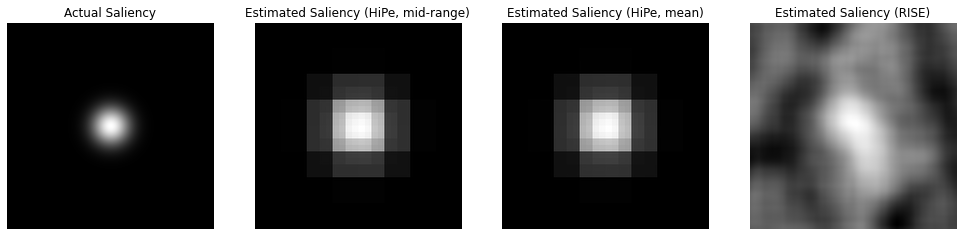

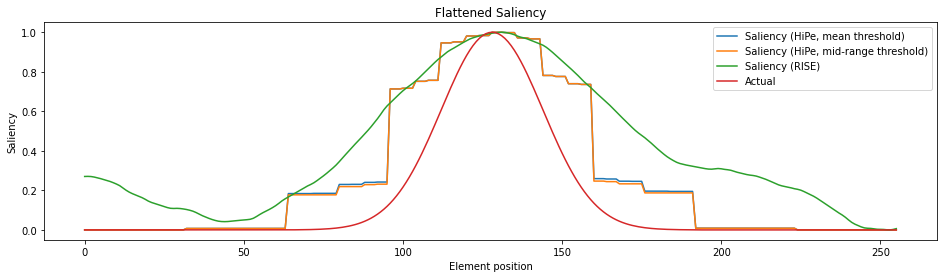

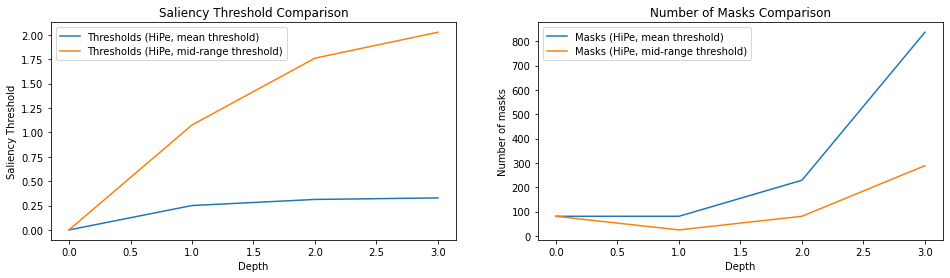

In [39]:

num_el = 256

f_sizes = [16]#[4,8,16,32,64]

def model(x):
    x = torch.sum(x, dim=(-1,-2), keepdim=True)
    return x

for f in f_sizes:
    input = gkern(num_el, f)[0,0].reshape(1,1,num_el, num_el)

    sal_rise = rise(model, input)
    sal_rise = sal_rise[:, 0, :, :].unsqueeze(1)

    sal_midrange, info_midrange = hierarchical_perturbation(model, input, 0, vis=False, perturbation_type='fade', batch_size=32, interp_mode='nearest', return_info=True)
    sal_mean, info_mean = hierarchical_perturbation(model, input, 0, vis=False, perturbation_type='fade', batch_size=32, interp_mode='nearest', threshold_mode='mean', return_info=True)

    input2 = input[:,:,num_el//2]
    sal_rise2 = sal_rise[:,:,num_el//2]
    sal_midrange2 = sal_midrange[:,:,num_el//2]
    sal_mean2 = sal_mean[:,:,num_el//2]

    t_mean, ms_mean, m_mean = info_mean.values()
    t_midrange, ms_midrange, m_midrange = info_midrange.values()
    print('Mean masks: {}, Mid-range masks: {}'.format(m_mean, m_midrange))
    print('\nComparison of HiPe with mean threshold, HiPe with mid-range threshold, and RISE\nSalient feature diameter {}'.format(f))
    plt.figure(figsize=(17, 8))
    ax = plt.subplot(1, 4, 1)
    ax.set_title("Actual Saliency")
    imsc(input[0])
    ax = plt.subplot(1, 4, 2)
    ax.set_title("Estimated Saliency (HiPe, mid-range)")
    imsc(sal_midrange[0])
    ax = plt.subplot(1, 4, 3)
    ax.set_title("Estimated Saliency (HiPe, mean)")
    imsc(sal_mean[0])
    ax = plt.subplot(1, 4, 4)
    ax.set_title("Estimated Saliency (RISE)")
    imsc(sal_rise[0])
    plt.show()


    plt.figure(figsize=(16, 4))
    pd.Series(normalise(sal_mean2).reshape(-1)).plot(label='Saliency ({})'.format('HiPe, mean threshold'))
    pd.Series(normalise(sal_midrange2).reshape(-1)).plot(label='Saliency ({})'.format('HiPe, mid-range threshold'))
    pd.Series(normalise(sal_rise2).reshape(-1)).plot(label='Saliency ({})'.format('RISE'))
    pd.Series(normalise(input2).reshape(-1)).plot(label='Actual')
    plt.xlabel('Element position')
    plt.ylabel('Saliency')
    plt.title('Flattened Saliency')
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 4))
    ax = plt.subplot(1, 2, 1)
    pd.Series(t_mean).plot(label='Thresholds ({})'.format('HiPe, mean threshold'))
    pd.Series(t_midrange).plot(label='Thresholds ({})'.format('HiPe, mid-range threshold'))
    plt.xlabel('Depth')
    plt.ylabel('Saliency Threshold')
    plt.title('Saliency Threshold Comparison')
    plt.legend()
    ax = plt.subplot(1,2,2)
    pd.Series(ms_mean).plot(label='Masks ({})'.format('HiPe, mean threshold'))
    pd.Series(ms_midrange).plot(label='Masks ({})'.format('HiPe, mid-range threshold'))
    plt.xlabel('Depth')
    plt.ylabel('Number of masks')
    plt.title('Number of Masks Comparison')
    plt.legend()
    plt.show()

In [40]:
num_el = 256

def model(x):
    x = torch.sum(x, dim=(-1,-2), keepdim=True)
    return x

input = normalise(gkern(num_el, 64)[0,0,num_el//2].reshape(1,1,1, num_el))

sal_midrange, info_midrange = hierarchical_perturbation(model, input, 0, vis=False, perturbation_type='fade', batch_size=32, interp_mode='nearest', return_info=True)
t_midrange, ms_midrange, m_midrange = info_midrange.values()



Believe the HiPe!
Num cells: 1
Max depth: -2
Used 0 masks in total.


(tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

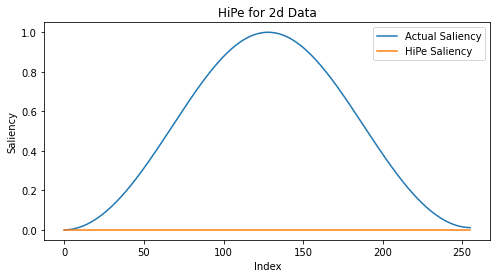

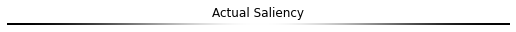

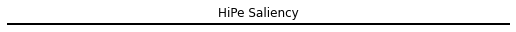

In [41]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 1, 1)
pd.Series(normalise(input).reshape(-1)).plot(label='Actual Saliency')
pd.Series(normalise(sal_midrange).reshape(-1)).plot(label='HiPe Saliency')
plt.xlabel('Index')
plt.ylabel('Saliency')
plt.title('HiPe for 2d Data')
plt.legend()
plt.figure(figsize=(9, 2))
plt.title("Actual Saliency")
imsc(input[0])
plt.figure(figsize=(9, 2))
plt.title("HiPe Saliency")
imsc(sal_midrange[0])

In [33]:

xds = [256]
yds=[256]
base=4

for x in xds:
    for y in yds:
        print('Input dims: {},{}'.format(x, y))
        num_y_cells = int(max(np.floor(np.log2(y)), 1))
        num_x_cells = int(max(np.floor(np.log2(x)), 1))
        print('Mask dims:  {},{}'.format(num_x_cells, num_y_cells))
       



Input dims: 256,256
Mask dims:  8,8
